# vine copula (vinecop)

- Fitting

> obs -> edge -> tree -> bcp -> (next lv) obs

The function `VineCop.fit` takes multivariate copula observations (of shape $(n,D)$ and values inside $(0,1)$). By default at each level, it proposes potential edges between (pseudo)observations under proximity conditions, calculates corresponding bivariate dependency metrics to determine bicops-to-fit using modified Kruskal's maximum spanning tree (MST, Dissmann 2013), then fit bicops and calculates pseudo-obs for the next level using their `hfunc`.

This function can make `VineCop` following c/d/r-vine restrictions using Dissmann algo, and can use existing structure matrix to make `VineCop`.

This function can prioritize vertices inside `first_tree_vertex` such that the fitted vine can be used to conduct **conditional simulation**.

- Simulation (inverse Rosenblatt transform)

The `sample_order` attribute inside a `VineCop` object shows sequentially (from right to left, from shallowest to deepest) `D` pseudo-observation (on `D` levels) as source vertices to walk `D` paths until their corresponding `D` target vertices on the top level. Along each path, iteratively we do `hinv` from lower vertex to upper vertex, but may (recursively) request `hfunc` if its opposite upper vertex is not available.

With `tpl_first` given during fitting, the fitted `VineCop` object allows for **conditional simulation**, where `dct_v_s_obs` can be specified for `.sample()`.


In [37]:
import sys
import platform
import matplotlib.pyplot as plt
import math
import torch
from torch.special import ndtr, ndtri
import torchvinecopulib as tvc
from torchvinecopulib.util import _EPS


DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Python:", sys.version.replace("\n", " "))
print("Platform:", platform.platform())
print("PyTorch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())

rho = 0.95
V = torch.randn(size=(10000, 2), dtype=torch.float64)
V[:, 1] = rho * V[:, 0] + math.sqrt(1 - rho**2) * V[:, 1]
VV = torch.randn(size=(5000, 2), dtype=torch.float64)
VV[:, 1] = -rho * VV[:, 0] + math.sqrt(1 - rho**2) * VV[:, 1]
V = ndtr(torch.vstack([V, VV])).clamp(_EPS, 1 - _EPS)
obs_mvcp = V
for _ in range(2):
    obs_mvcp = torch.hstack(
        [
            obs_mvcp,
            torch.hstack(
                [
                    obs_mvcp[torch.randperm(obs_mvcp.shape[0]), [0]].reshape(-1, 1),
                    obs_mvcp[torch.randperm(obs_mvcp.shape[0]), [1]].reshape(-1, 1),
                ]
            ),
        ]
    )
obs_mvcp = obs_mvcp[:1000, :7]

Python: 3.13.3 (main, Apr  8 2025, 13:54:08) [Clang 16.0.0 (clang-1600.0.26.6)]
Platform: macOS-15.3.2-arm64-arm-64bit-Mach-O
PyTorch: 2.7.0
CUDA available: False


In [19]:
num_step_grid = 32
mdl_vcp = tvc.vinecop.VineCop(num_dim=obs_mvcp.shape[1], num_step_grid=num_step_grid)
mdl_vcp.fit(obs_mvcp=obs_mvcp, mtd_vine="rvine", first_tree_vertex=(0, 5))
print(mdl_vcp)

VineCop
'num_dim': 6,
 'num_obs': 1_000,
 'mtd_bidep': 'chatterjee_xi',
 'negloglik': -11.6833,
 'num_step_grid': 32,
 'dtype': torch.float64,
 'device': 'cpu',
 'sample_order': (3, 4, 1, 2, 0, 5),
 'matrix':
    tensor([[ 3,  4,  1,  0,  5,  2],
            [-1,  4,  2,  5,  0,  1],
            [-1, -1,  1,  2,  5,  0],
            [-1, -1, -1,  2,  0,  5],
            [-1, -1, -1, -1,  0,  5],
            [-1, -1, -1, -1, -1,  5]], dtype=torch.int32)




(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Vine level 1'}>,
 <networkx.classes.graph.Graph at 0x16bf9c050>)

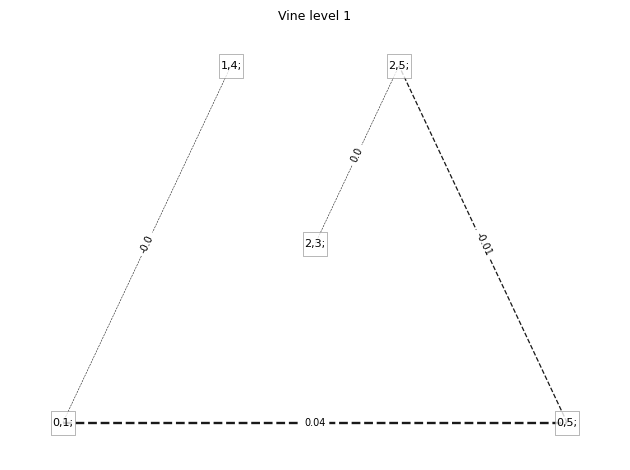

In [22]:
mdl_vcp.draw_lv(lv=1, is_bcp=True)

(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Vine comp graph'}>,
 <networkx.classes.digraph.DiGraph at 0x16bac6ea0>)

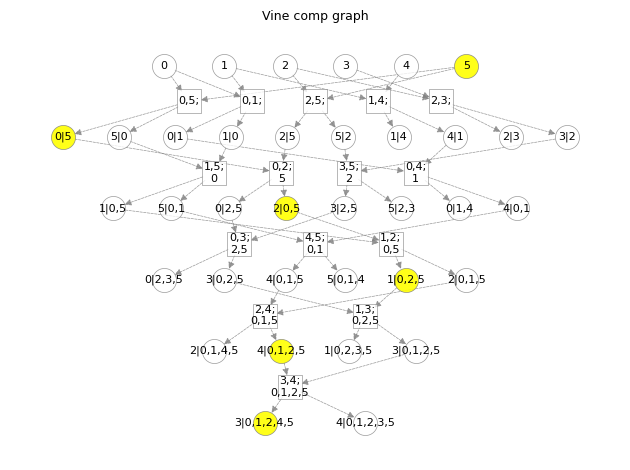

In [20]:
mdl_vcp.draw_dag()

## inside a VineCop obj

- $\frac{D(D-1)}{2}$ bicops (`torch.nn.Module` inside `ModuleDict`)
- parents of bicops
- parents of pseudo-obs
- a `staticmethod` oracle to query the number of h-function calls (and source vertices) given a sampling order on a vine


<Axes: title={'center': 'Estimated bivariate copula density'}, xlabel='$u_1$', ylabel='$u_2$'>

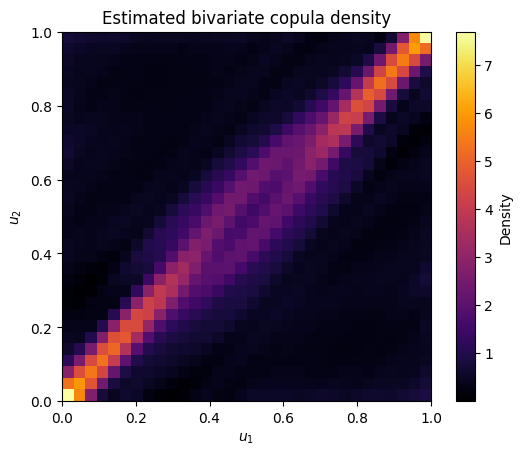

In [36]:
next(iter(mdl_vcp.bicops.values())).imshow()

In [14]:
print(mdl_vcp.bicops, mdl_vcp.struct_bcp, mdl_vcp.struct_obs)
mdl_vcp.ref_count_hfunc(
    num_dim=mdl_vcp.num_dim,
    struct_obs=mdl_vcp.struct_obs,
    sample_order=mdl_vcp.sample_order,
)

ModuleDict(
  (0,1): BiCop()
  (0,2): BiCop()
  (0,3): BiCop()
  (0,4): BiCop()
  (0,5): BiCop()
  (1,2): BiCop()
  (1,3): BiCop()
  (1,4): BiCop()
  (1,5): BiCop()
  (2,3): BiCop()
  (2,4): BiCop()
  (2,5): BiCop()
  (3,4): BiCop()
  (3,5): BiCop()
  (4,5): BiCop()
) {'0,1': {'cond_ed': (0, 1), 'cond_ing': (), 'is_indep': False, 'left': '', 'right': ''}, '0,2': {'cond_ed': (0, 2), 'cond_ing': (), 'is_indep': False, 'left': '', 'right': ''}, '0,3': {'cond_ed': (0, 3), 'cond_ing': (), 'is_indep': False, 'left': '', 'right': ''}, '0,4': {'cond_ed': (0, 4), 'cond_ing': (), 'is_indep': False, 'left': '', 'right': ''}, '0,5': {'cond_ed': (0, 5), 'cond_ing': (), 'is_indep': False, 'left': '', 'right': ''}, '1,2': {'cond_ed': (1, 2), 'cond_ing': (0, 3, 4, 5), 'is_indep': False, 'left': '1,3', 'right': '2,3'}, '1,3': {'cond_ed': (1, 3), 'cond_ing': (0, 4, 5), 'is_indep': False, 'left': '1,4', 'right': '3,4'}, '1,4': {'cond_ed': (1, 4), 'cond_ing': (0, 5), 'is_indep': False, 'left': '1,5', 'rig

({(0,): 6,
  (5,): 1,
  (5, 0): 5,
  (4, 0): 2,
  (4, 0, 5): 4,
  (4,): 1,
  (3, 0, 5): 2,
  (3, 0, 4, 5): 3,
  (3, 0): 2,
  (3,): 1,
  (2, 0, 4, 5): 2,
  (2, 0, 3, 4, 5): 2,
  (2, 0, 5): 2,
  (2, 0): 2,
  (2,): 1,
  (1, 0, 3, 4, 5): 2,
  (1, 0, 2, 3, 4, 5): 1,
  (1, 0, 4, 5): 2,
  (1, 0, 5): 2,
  (1, 0): 2,
  (1,): 1},
 [(0,), (5, 0), (4, 0, 5), (3, 0, 4, 5), (2, 0, 3, 4, 5), (1, 0, 2, 3, 4, 5)],
 1)

## log_pdf, cdf


In [ ]:
mdl_vcp.log_pdf(obs_mvcp=obs_mvcp)

tensor([[ 5.5365e-01],
        [-2.2569e-01],
        [-7.1969e-01],
        [ 8.8591e-01],
        [ 2.1654e-01],
        [-4.8759e-02],
        [-5.3037e-01],
        [ 8.5168e-01],
        [ 7.1608e-01],
        [-1.9912e-02],
        [-2.4159e-01],
        [-3.1506e-01],
        [ 4.6100e-01],
        [ 1.0258e-01],
        [ 4.6153e-01],
        [ 4.9671e-02],
        [ 8.1932e-01],
        [-4.0307e-01],
        [ 6.0181e-01],
        [ 6.0524e-01],
        [-3.4300e-01],
        [-1.0434e+00],
        [ 6.1878e-02],
        [ 8.4829e-02],
        [-2.0699e-01],
        [ 5.9352e-01],
        [ 3.8607e-01],
        [ 4.2214e-01],
        [-4.2934e-03],
        [ 5.5841e-01],
        [ 5.2494e-01],
        [ 3.0703e-01],
        [-5.1387e-01],
        [-1.1019e+00],
        [-1.4615e+00],
        [ 6.3061e-01],
        [-2.8384e-02],
        [-8.5321e-01],
        [-2.1867e-01],
        [ 3.2127e-01],
        [-4.2629e-01],
        [-1.6508e-01],
        [-3.9112e-01],
        [-8

In [32]:
mdl_vcp.cdf(obs_mvcp=obs_mvcp)

tensor([[2.3020e-02],
        [3.6800e-03],
        [2.1460e-02],
        [1.4400e-03],
        [1.4160e-02],
        [3.3400e-03],
        [8.1300e-02],
        [1.0000e-03],
        [1.0720e-02],
        [4.3800e-03],
        [4.0220e-02],
        [6.4000e-04],
        [1.8000e-04],
        [1.1840e-02],
        [1.2600e-03],
        [2.6600e-02],
        [5.9960e-02],
        [1.2076e-01],
        [1.9360e-02],
        [1.5740e-02],
        [4.8580e-02],
        [1.9820e-02],
        [1.9480e-02],
        [8.6000e-04],
        [2.8800e-03],
        [3.4600e-03],
        [3.0880e-02],
        [1.8000e-03],
        [1.6440e-02],
        [1.6760e-02],
        [1.1000e-03],
        [1.3000e-03],
        [3.4800e-03],
        [3.9780e-02],
        [1.3860e-02],
        [4.0000e-05],
        [4.7000e-03],
        [2.9400e-03],
        [1.0200e-03],
        [6.6020e-02],
        [3.7380e-02],
        [6.2780e-02],
        [4.2840e-02],
        [3.9080e-02],
        [1.0304e-01],
        [1

# (conditional) sampling

* default sampling given $0$ columns of observations
* quantile regression given $D-1$ columns of observations
* conditional simulation otherwise


In [17]:
mdl_vcp.sample()

tensor([[5.8154e-02, 8.6635e-02, 5.5581e-01, 5.0000e-08, 7.2138e-02, 3.1415e-02],
        [9.5524e-01, 8.9420e-01, 6.7335e-02, 6.7914e-02, 2.8912e-02, 9.5970e-01],
        [8.4252e-01, 8.7932e-01, 5.0000e-08, 6.5164e-01, 3.6493e-01, 8.9873e-01],
        ...,
        [8.3116e-01, 5.3797e-02, 1.0000e+00, 7.4183e-01, 1.0000e+00, 3.1219e-01],
        [8.5979e-01, 1.0000e+00, 1.0593e-01, 5.0000e-08, 1.6153e-01, 8.2832e-01],
        [8.9260e-01, 1.0000e+00, 9.9053e-01, 5.0000e-08, 6.1083e-01, 7.4675e-01]],
       dtype=torch.float64)

In [23]:
mdl_vcp.sample_order

(3, 4, 1, 2, 0, 5)

In [30]:
mdl_vcp.sample(
    num_sample=1000,
    is_sobol=True,
    sample_order=mdl_vcp.sample_order[:-2],
    dct_v_s_obs={
        (mdl_vcp.sample_order[-1],): torch.ones(size=(1000, 1), device=obs_mvcp.device),
        (mdl_vcp.sample_order[-2],): torch.zeros(
            size=(1000, 1), device=obs_mvcp.device
        ),
    },
)

tensor([[1.0000e-07, 5.0000e-08, 1.0000e+00, 4.5015e-01, 9.2658e-01, 1.0000e+00],
        [1.0000e-07, 9.1761e-01, 4.5998e-01, 6.4714e-01, 5.0000e-08, 1.0000e+00],
        [1.0000e-07, 2.6821e-02, 1.8998e-01, 3.7408e-02, 7.6612e-01, 1.0000e+00],
        ...,
        [1.0000e-07, 1.0000e+00, 1.6442e-02, 7.6133e-01, 5.9877e-01, 1.0000e+00],
        [1.0000e-07, 4.3129e-02, 3.2543e-01, 5.0000e-08, 5.0000e-08, 1.0000e+00],
        [1.0000e-07, 5.0740e-01, 9.0413e-01, 1.0000e+00, 7.3774e-01, 1.0000e+00]],
       dtype=torch.float64)